<center> <h1> <b>DATA AUGMENTATION<b></h1> </center>
<center> <h2>Tutorial</h2> </center>

## Defining Objects

In [111]:
%matplotlib ipympl

import birdsongs as bs
from birdsongs.util import *

In [115]:
root    = "../examples/"
audios = "/media/sebas/GamesExt/whole_audios/"
results = "results" 

paths  = bs.Paths(root, audios, results, catalog=True)
ploter = bs.Ploter(save=False)

df_col = paths.ImportParameters(country_filter="Colombia")
df_bra = paths.ImportParameters(country_filter="Brazil")
df_bra

5 files were found.
5 files were found.


,id_XC,no_syllable,id,name,coef_path,audio_path,file_name,t_ini,t_end,NN,umbral_FF,coef,type,country,state
3,19332,0,syllable,s-syllable,../examples/results/MG/19332-s-syllable-0-MG.csv,/media/sebas/GamesExt/whole_audios/19332.wav,19332.wav,43.883286,44.044443,256,1.05,"[0.046000000000000006, 0.0, 0.0, -0.1750000000...",intro-down,Brazil,Rio Grande do Sul


### Importing Birdsong

In [116]:
index = 3
birdsong = DefineWholeSyllable(paths, df_col, index, flim=(1e2,15e3))

#print("Country: {}, State: {}".format(birdsong.country, birdsong.state))
#ploter.Plot(birdsong, FF_on=False, SelectTime_on=False, figsize=(11,5))
#AudioPlay(birdsong)

### Import Syllable

/home/sebas/anaconda3/lib/python3.11/site-packages/librosa-0.10.1-py3.11.egg/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


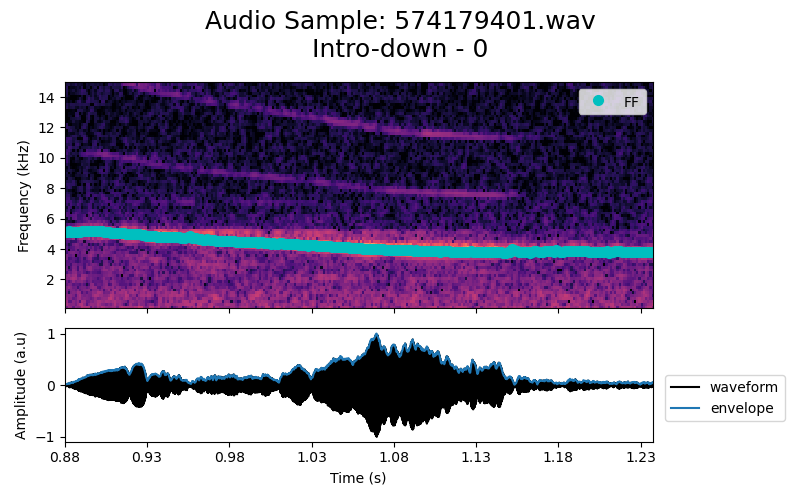

In [117]:
syllable, synth_syllable, bw_rate = DefineSyllable(paths, df_col, index, flim=(1e2,15e3))

ploter.Plot(syllable, FF_on=True)
AudioPlay(syllable)

### Results

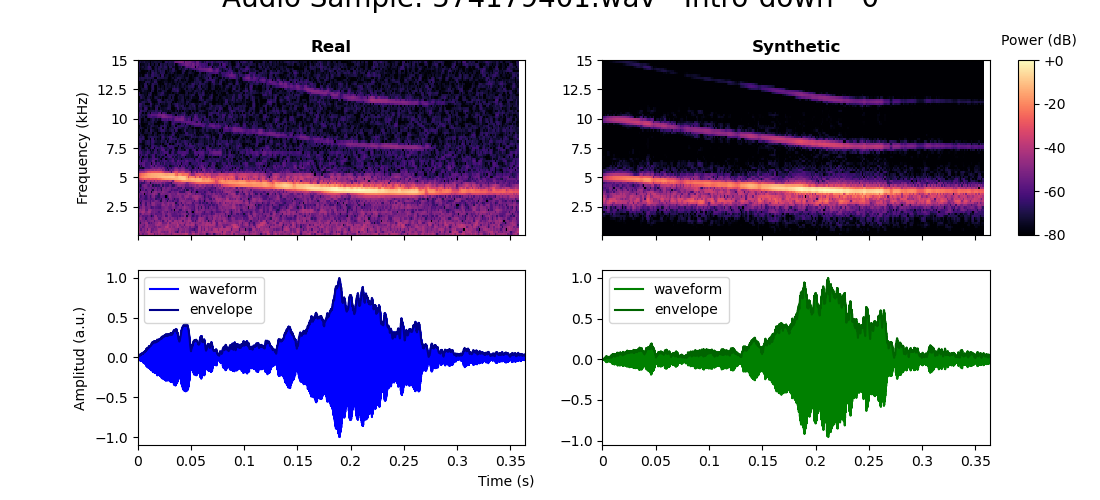

In [120]:
ploter.Syllables(syllable, synth_syllable, figsize=(11,5));

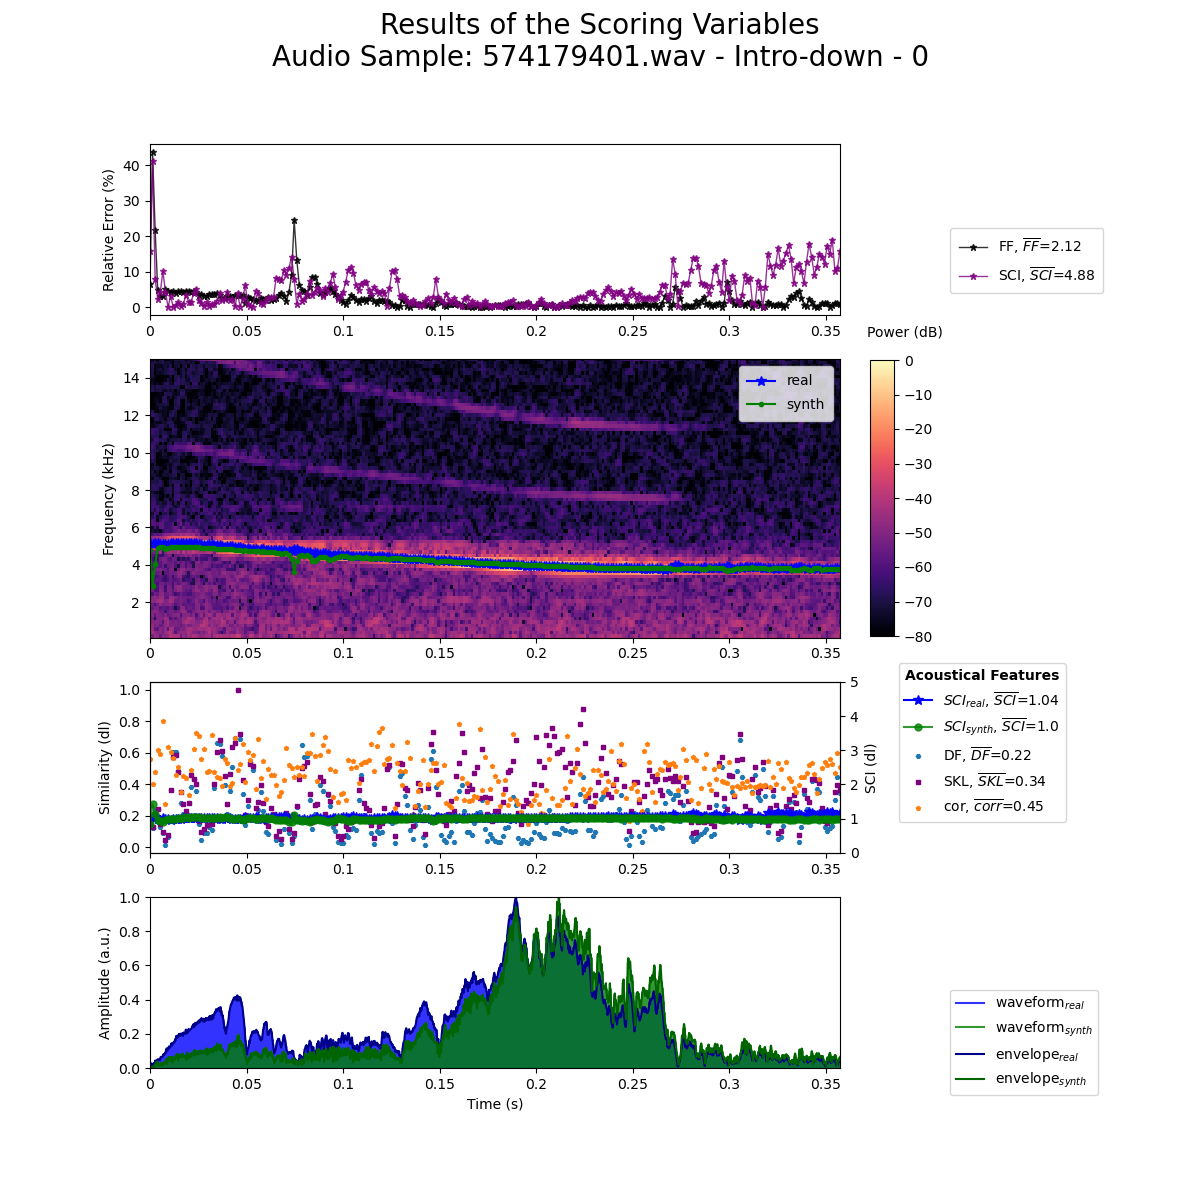

In [119]:
ploter.Scores(syllable, synth_syllable, figsize=(12,12));

## Data Augmentation

In [121]:
%%capture

import random

df = df_col.copy()
NO_SAMPLES = 40
PERCENTAGE = 50/100 # 10 %
flim = (1e2,2e4)

file_id = df.iloc[index]["id_XC"]
NN = df.iloc[index]["NN"]
umbral_FF = df.iloc[index]["umbral_FF"]
time_interval = df.iloc[index][["t_ini","t_end"]].values
type = df.iloc[index]["type"]
no_syllable = df.iloc[index]["no_syllable"]
coef_original = df.iloc[index][["coef"]].values[0]

birdsong = bs.BirdSong(paths, file_id=file_id, umbral_FF=umbral_FF, tlim=(0,60), Nt=1000, NN=NN, flim=flim)

df_data_augmented = pd.DataFrame()

dataa = pd.DataFrame(df.iloc[index]).copy().T
dataa["coef"].iloc[0] = coef_original
dataa["delta_FF"] = 0
dataa["delta_SCI"] = 0
dataa["SKL"] = 0
dataa["DF"] = 0
dataa["correlation"] = 0
df_data_augmented = pd.concat([df_data_augmented, dataa])

syllables, coefs, labels = [], [], []
j_index, jj = ["a0","b0","b1"], 0
for i in range(NO_SAMPLES):
    for j in [0,3,4]: # index a0,b0,b1
        coef = df.iloc[index][["coef"]].values[0].copy()
        coef[j] = str(float(coef_original[j])*(1+PERCENTAGE*random.uniform(-1,1)))
        
        dataa = pd.DataFrame(df.iloc[index]).copy().T
        dataa["coef"].iloc[0] = coef
        dataa["delta_FF"] = synth_syllable.deltaFF_mean
        dataa["delta_SCI"] = synth_syllable.deltaSCI_mean
        dataa["SKL"] = synth_syllable.SKL.mean()
        dataa["DF"] = synth_syllable.Df.mean()
        dataa["correlation"] = synth_syllable.correlation.mean()
        df_data_augmented = pd.concat([df_data_augmented, dataa])
        
        syllable = bs.Syllable(birdsong=birdsong, tlim=time_interval, Nt=10, umbral_FF=umbral_FF, ide="syllable", type=type, no_syllable=no_syllable)
        syllable.Set(coef)
        synth_syllable = syllable.Solve(syllable.p)
        
        labels.append("{}: {}={}".format(i,j_index[jj],str(round(float(coef[j]),4))))
        syllables.append(synth_syllable)
        coefs.append(coef)
        
        jj+=1
    jj=0

df_data_augmented = df_data_augmented.reset_index(drop=True)

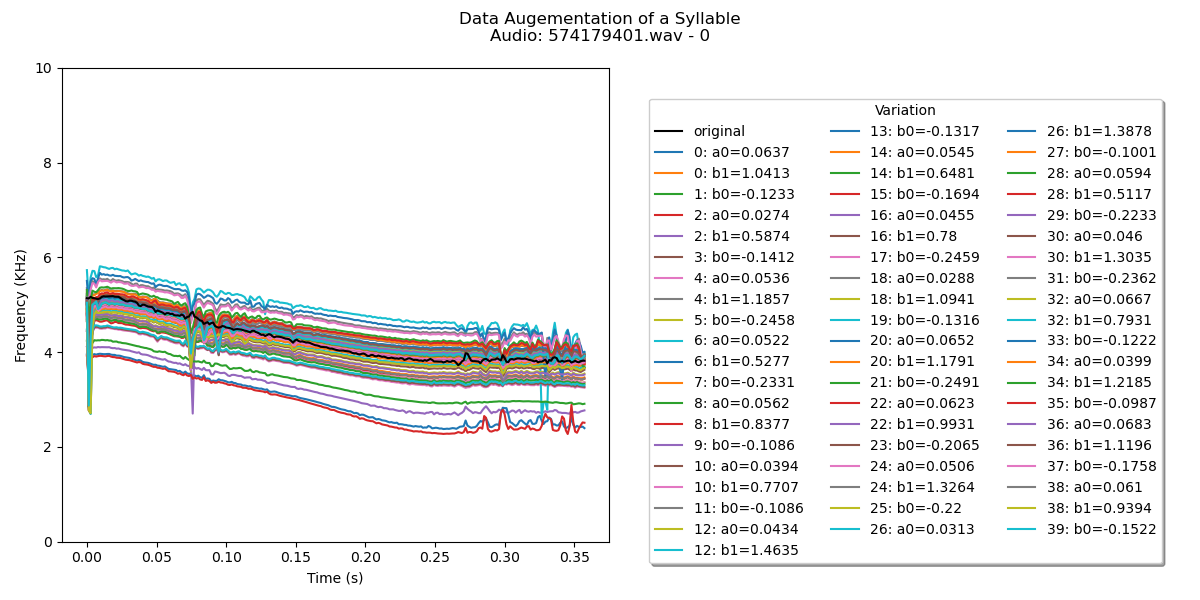

In [122]:
MOD = 2
figsize = (12,6)
ncol = 3
fig, ax = plt.subplots(figsize=figsize)

ax.plot(syllable.time, syllable.FF/1e3, color="black", label="original")#+str(round(float(coef_original[3]),4)))
for i in range(len(syllables)):
    if i%MOD==0: ax.plot(syllables[i].time, syllables[i].FF/1e3, label=labels[i])

ax.plot(syllable.time, syllable.FF/1e3, color="black")
ax.legend(title="Variation",bbox_to_anchor=(1.+0.02*ncol, 0.95), shadow=True, ncol=ncol)#, fontsize='x-large') # loc='upper center'
plt.xlabel("Time (s)"); plt.ylabel("Frequency (KHz)")
plt.ylim((0, 10))
plt.suptitle("Data Augementation of a Syllable\nAudio: {} - {}".format(syllable.file_name, syllable.no_syllable))

fig.tight_layout()
plt.show()


name  = "{}-{}-{}-{}.csv".format(syllable.file_name[:-4],syllable.id,syllable.no_syllable,NO_SAMPLES*3)
syllable.paths.DataAugmented = syllable.paths.MG_param / "DataAugmented"
df_data_augmented.to_csv(syllable.paths.DataAugmented / name, index=True)

104


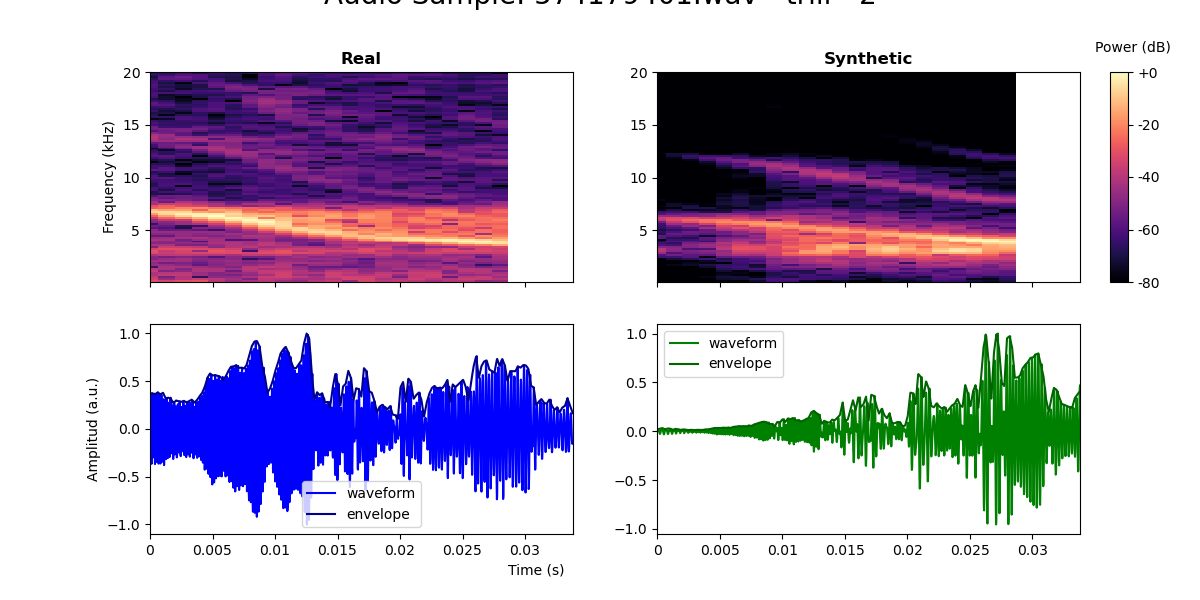

In [109]:
indice = random.randint(0,120)
print(indice)
ploter.Syllables(syllable, syllables[indice]);

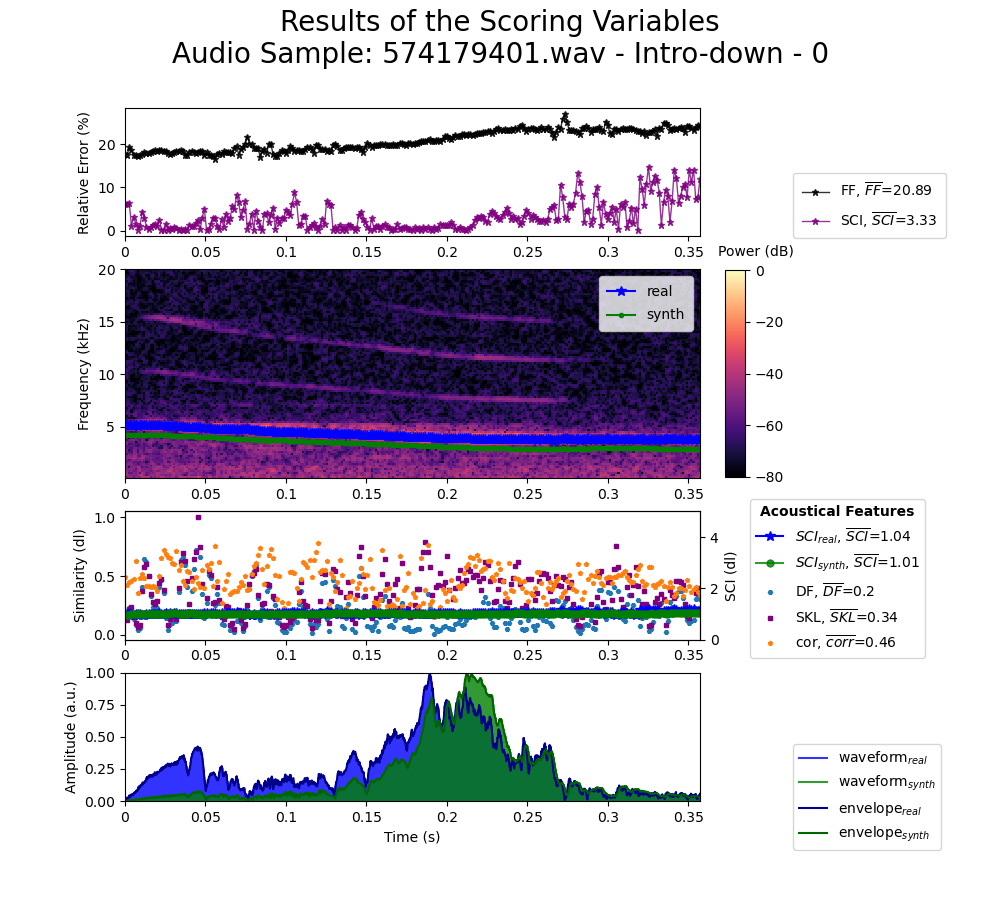

In [87]:
ploter.Scores(syllable, syllables[indice]);